In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importar librerías necesarias
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


In [2]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_historic_order_demand.xlsx"
df_historic_order_demand = pd.read_excel(path_df_location)

path_df_location = "../dataset/df_location.xlsx"
df_location = pd.read_excel(path_df_location)

path_df_vehicle = "../dataset/df_vehicle.xlsx"
df_vehicle = pd.read_excel(path_df_vehicle)

path_df_orders = "../dataset/df_orders.xlsx"
df_orders = pd.read_excel(path_df_orders)

path_df_distance_km = "../dataset/df_distance_km.xlsx"
df_distance_km = pd.read_excel(path_df_distance_km)

In [3]:
df_orders.head()

,cliente,mes_anio,order_demand
0,Cliente_1,12-2024,909
1,Cliente_2,12-2024,959
2,Cliente_3,12-2024,960
3,Cliente_4,12-2024,980
4,Cliente_5,12-2024,979


In [4]:
# Explorar la estructura del DataFrame
print("Primeras filas del DataFrame:")
print(df_historic_order_demand.head())

print("\nInformación del DataFrame:")
print(df_historic_order_demand.info())

# Verificar si hay valores nulos
print("\nValores nulos por columna:")
print(df_historic_order_demand.isnull().sum())


Primeras filas del DataFrame:
     cliente mes_anio  order_demand
0  Cliente_1  12-2020         857.0
1  Cliente_2  12-2020         941.0
2  Cliente_3  12-2020         878.0
3  Cliente_4  12-2020         949.0
4  Cliente_5  12-2020         932.0

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cliente       980 non-null    object 
 1   mes_anio      980 non-null    object 
 2   order_demand  932 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.1+ KB
None

Valores nulos por columna:
cliente          0
mes_anio         0
order_demand    48
dtype: int64


In [5]:
# Crear una nueva columna 'mes_anio_dia' con los datos en formato datetime
df_historic_order_demand['mes_anio_dia'] = pd.to_datetime(df_historic_order_demand['mes_anio'], format='%m-%Y', errors='coerce')

# Verificar si hay valores nulos en la nueva columna
print("\nValores nulos en 'mes_anio_dia':")
print(df_historic_order_demand['mes_anio_dia'].isnull().sum())


Valores nulos en 'mes_anio_dia':
0


In [7]:
# Verificar si hay duplicados basados en 'cliente' y 'mes_anio'
print("Registros duplicados:")
print(df_historic_order_demand.duplicated(subset=['cliente', 'mes_anio_dia']).sum())

Registros duplicados:
0


In [8]:
# Imprimir una muestra para verificar el resultado
print("Datos preprocesados:")
print(df_historic_order_demand.head())

Datos preprocesados:
     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_2  12-2020         941.0   2020-12-01
2  Cliente_3  12-2020         878.0   2020-12-01
3  Cliente_4  12-2020         949.0   2020-12-01
4  Cliente_5  12-2020         932.0   2020-12-01


In [9]:
# Ordenar primero por cliente y luego por mes_anio_dia
df_historic_order_demand = df_historic_order_demand.sort_values(by=['cliente', 'mes_anio_dia']).reset_index(drop=True)

# Verificar la estructura después de ordenar
print(df_historic_order_demand.head())  # Muestra las primeras filas para confirmar

     cliente mes_anio  order_demand mes_anio_dia
0  Cliente_1  12-2020         857.0   2020-12-01
1  Cliente_1  01-2021         768.0   2021-01-01
2  Cliente_1  02-2021         635.0   2021-02-01
3  Cliente_1  03-2021         631.0   2021-03-01
4  Cliente_1  04-2021         589.0   2021-04-01


In [10]:
# Mostrar número de valores nulos en la columna 'order_demand'
print("\nValores nulos en 'order_demand':")
print(df_historic_order_demand['order_demand'].isnull().sum())

# Mostrar las filas que contienen valores nulos en 'order_demand'
print("\nFilas con valores nulos en 'order_demand':")
print(df_historic_order_demand[df_historic_order_demand['order_demand'].isnull()])



Valores nulos en 'order_demand':
48

Filas con valores nulos en 'order_demand':
        cliente mes_anio  order_demand mes_anio_dia
55   Cliente_10  06-2021           NaN   2021-06-01
65   Cliente_10  04-2022           NaN   2022-04-01
89   Cliente_10  04-2024           NaN   2024-04-01
92   Cliente_10  07-2024           NaN   2024-07-01
109  Cliente_11  11-2021           NaN   2021-11-01
124  Cliente_11  02-2023           NaN   2023-02-01
128  Cliente_11  06-2023           NaN   2023-06-01
140  Cliente_11  06-2024           NaN   2024-06-01
169  Cliente_12  10-2022           NaN   2022-10-01
173  Cliente_12  02-2023           NaN   2023-02-01
205  Cliente_13  09-2021           NaN   2021-09-01
211  Cliente_13  03-2022           NaN   2022-03-01
229  Cliente_13  09-2023           NaN   2023-09-01
234  Cliente_13  02-2024           NaN   2024-02-01
253  Cliente_14  08-2021           NaN   2021-08-01
254  Cliente_14  09-2021           NaN   2021-09-01
275  Cliente_14  06-2023           

In [11]:
# Sustituir los valores nulos en 'order_demand' por ceros
df_historic_order_demand['order_demand'] = df_historic_order_demand['order_demand'].fillna(0)

# Verificar si quedan valores nulos
print("\nVerificación de valores nulos después de la sustitución:")
print(df_historic_order_demand['order_demand'].isnull().sum())



Verificación de valores nulos después de la sustitución:
0


In [12]:
df_historic_order_demand

,cliente,mes_anio,order_demand,mes_anio_dia
0,Cliente_1,12-2020,857.0,2020-12-01
1,Cliente_1,01-2021,768.0,2021-01-01
2,Cliente_1,02-2021,635.0,2021-02-01
3,Cliente_1,03-2021,631.0,2021-03-01
4,Cliente_1,04-2021,589.0,2021-04-01
...,...,...,...,...
975,Cliente_9,08-2024,662.0,2024-08-01
976,Cliente_9,09-2024,637.0,2024-09-01
977,Cliente_9,10-2024,627.0,2024-10-01
978,Cliente_9,11-2024,613.0,2024-11-01


Dividir los Datos por Cliente


In [13]:
# Crear un diccionario para almacenar los datos por cliente
clientes_data = {}

# Iterar por cada cliente único y guardar sus datos en un DataFrame
for cliente in df_historic_order_demand['cliente'].unique():
    datos_cliente = df_historic_order_demand[df_historic_order_demand['cliente'] == cliente]
    
    # Solo incluir si hay datos válidos para análisis temporal
    if datos_cliente['order_demand'].notnull().sum() > 12:  # Al menos 12 puntos de datos
        clientes_data[cliente] = datos_cliente

# Confirmar cuántos clientes tienen datos suficientes para análisis
print(f"{len(clientes_data)} clientes tienen datos suficientes para análisis temporal.")


20 clientes tienen datos suficientes para análisis temporal.


In [20]:
clientes_data

{'Cliente_1':       cliente mes_anio  order_demand mes_anio_dia
 0   Cliente_1  12-2020         857.0   2020-12-01
 1   Cliente_1  01-2021         768.0   2021-01-01
 2   Cliente_1  02-2021         635.0   2021-02-01
 3   Cliente_1  03-2021         631.0   2021-03-01
 4   Cliente_1  04-2021         589.0   2021-04-01
 5   Cliente_1  05-2021         785.0   2021-05-01
 6   Cliente_1  06-2021         798.0   2021-06-01
 7   Cliente_1  07-2021         599.0   2021-07-01
 8   Cliente_1  08-2021         570.0   2021-08-01
 9   Cliente_1  09-2021         589.0   2021-09-01
 10  Cliente_1  10-2021        1848.0   2021-10-01
 11  Cliente_1  11-2021         597.0   2021-11-01
 12  Cliente_1  12-2021         886.0   2021-12-01
 13  Cliente_1  01-2022         699.0   2022-01-01
 14  Cliente_1  02-2022         609.0   2022-02-01
 15  Cliente_1  03-2022         633.0   2022-03-01
 16  Cliente_1  04-2022         563.0   2022-04-01
 17  Cliente_1  05-2022         816.0   2022-05-01
 18  Cliente_1  06

1. Descomposición de Series Temporales

Descomponiendo serie temporal para Cliente_1...


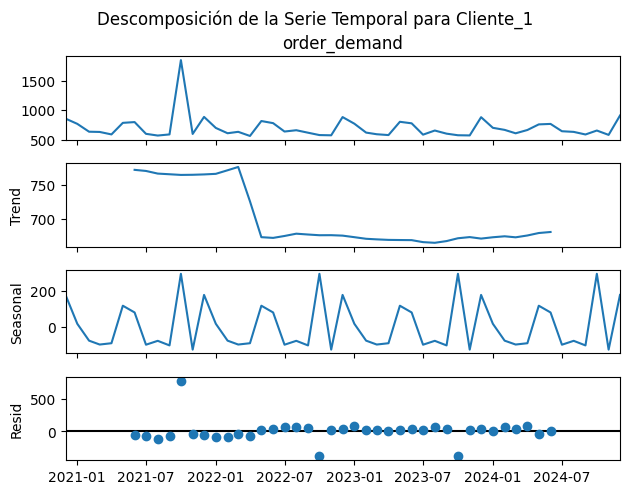

Descomponiendo serie temporal para Cliente_10...


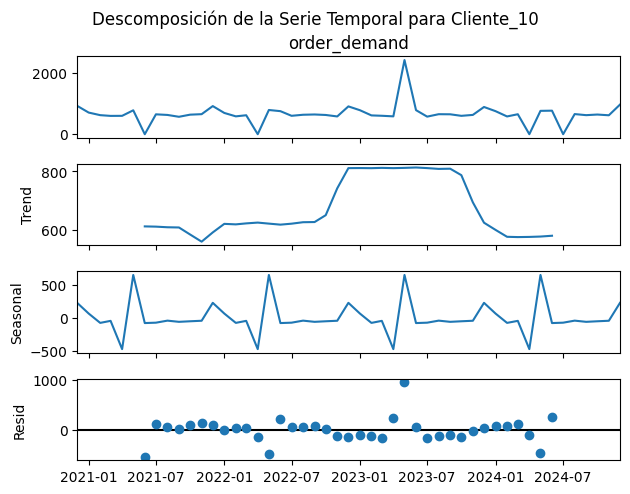

Descomponiendo serie temporal para Cliente_11...


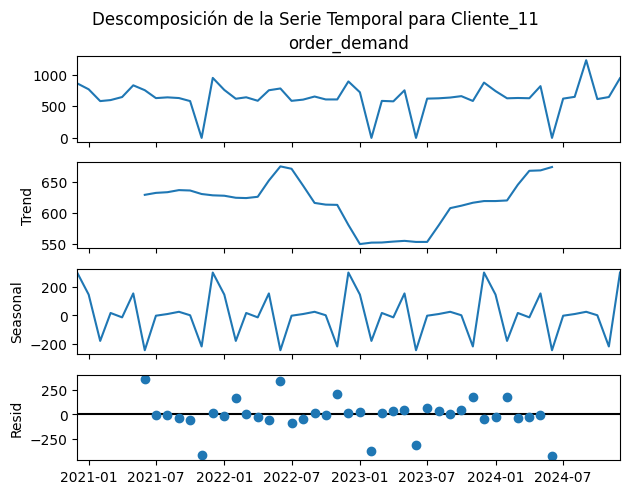

Descomponiendo serie temporal para Cliente_12...


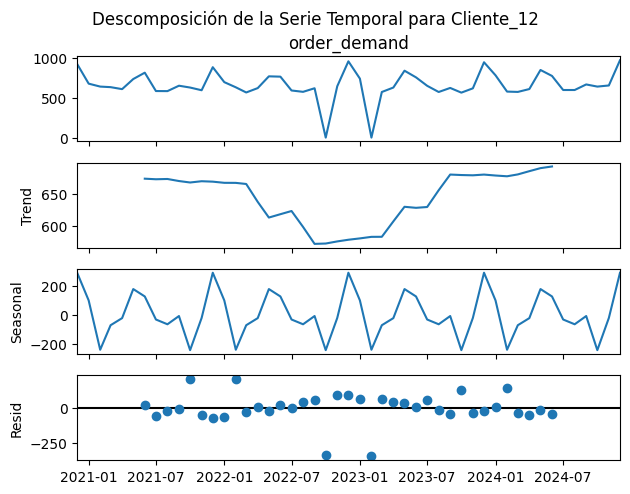

Descomponiendo serie temporal para Cliente_13...


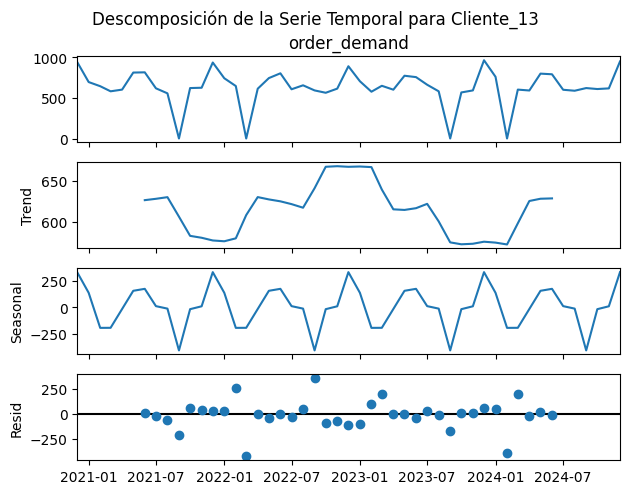

Descomponiendo serie temporal para Cliente_14...


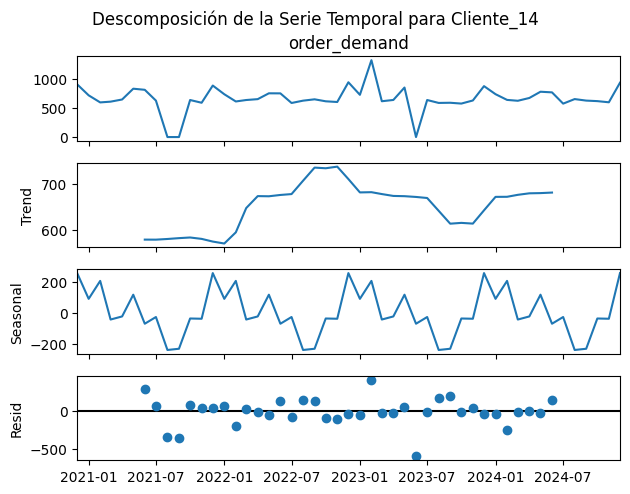

Descomponiendo serie temporal para Cliente_15...


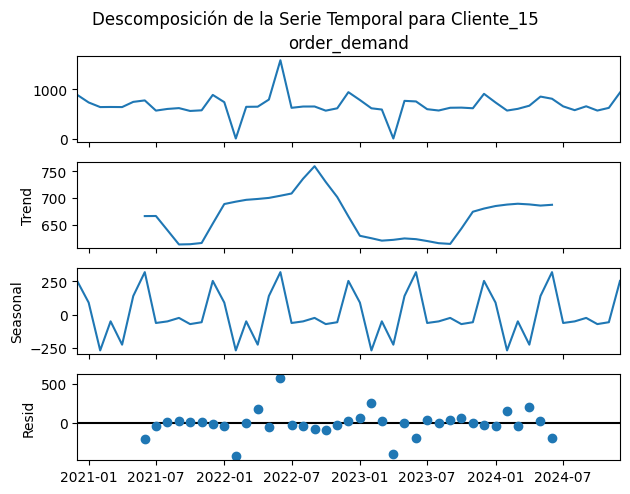

Descomponiendo serie temporal para Cliente_16...


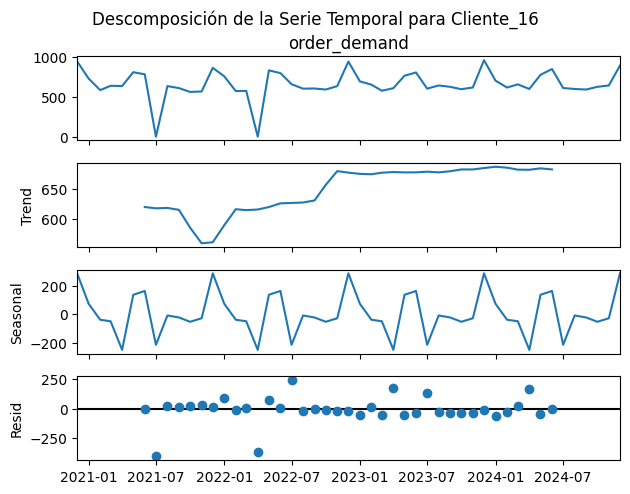

Descomponiendo serie temporal para Cliente_17...


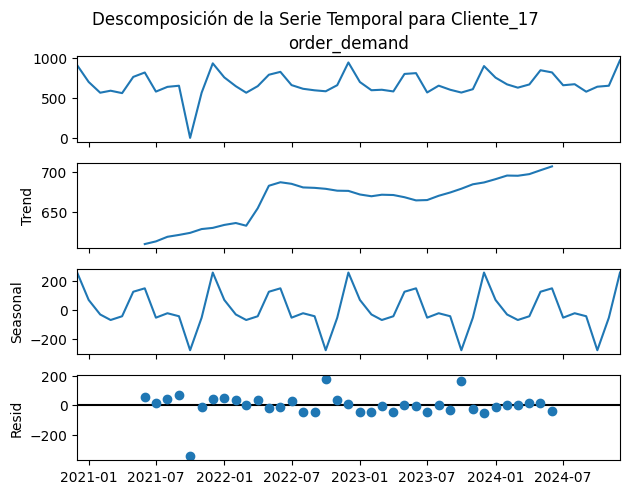

Descomponiendo serie temporal para Cliente_18...


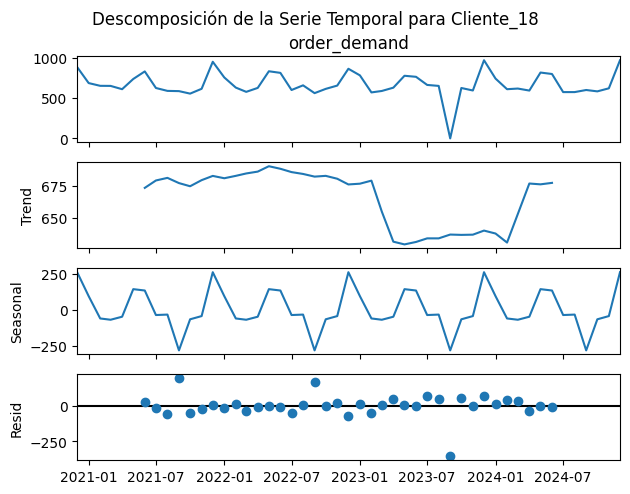

Descomponiendo serie temporal para Cliente_19...


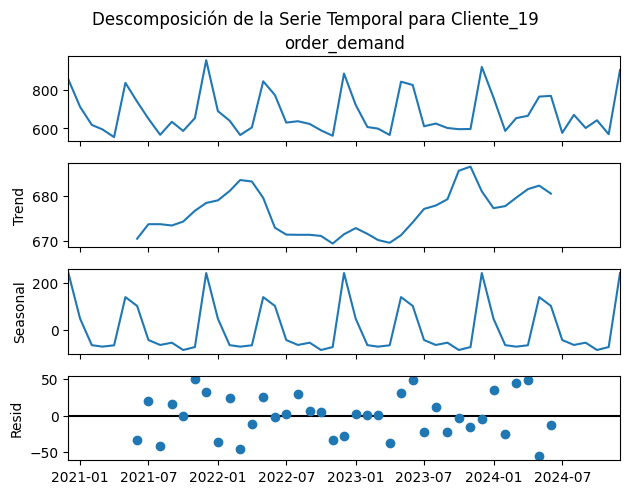

Descomponiendo serie temporal para Cliente_2...


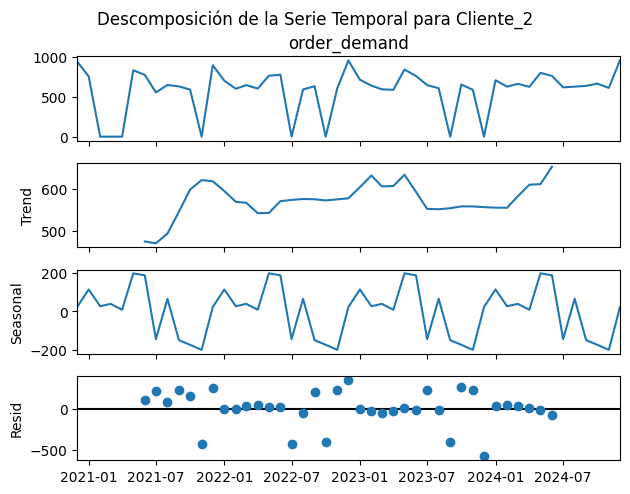

Descomponiendo serie temporal para Cliente_20...


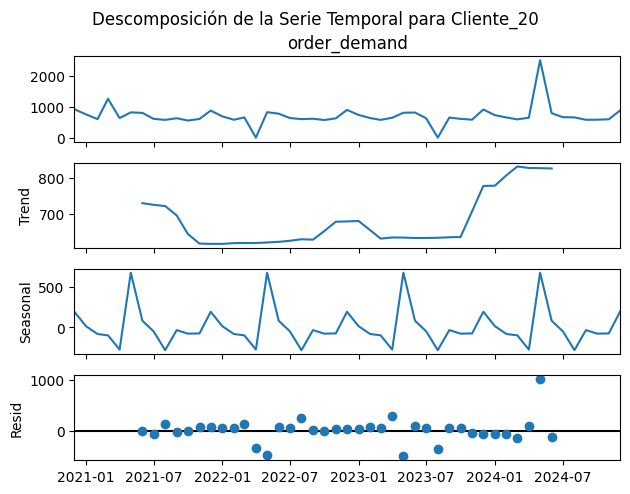

Descomponiendo serie temporal para Cliente_3...


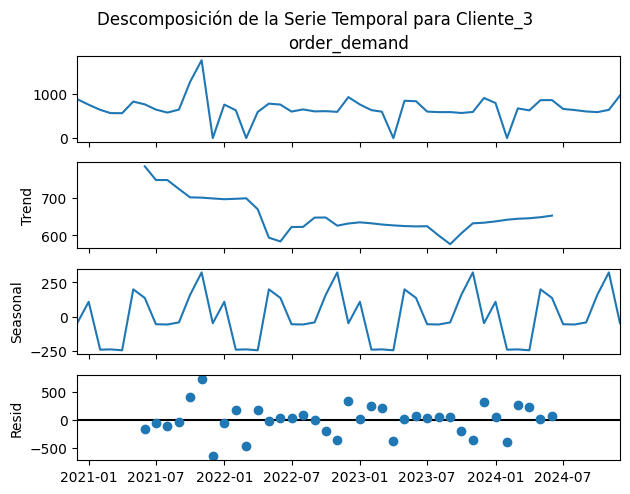

Descomponiendo serie temporal para Cliente_4...


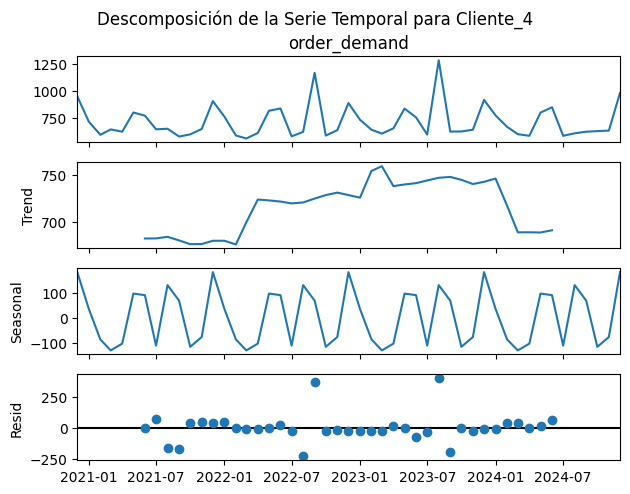

Descomponiendo serie temporal para Cliente_5...


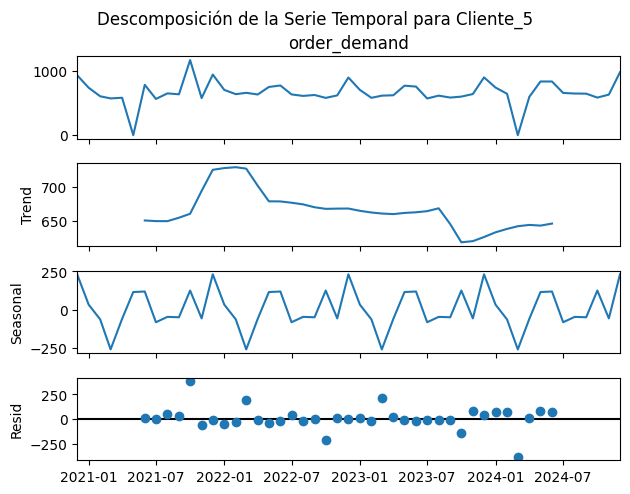

Descomponiendo serie temporal para Cliente_6...


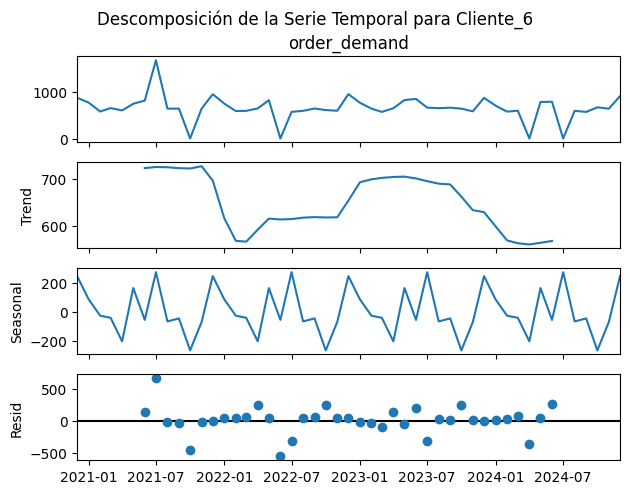

Descomponiendo serie temporal para Cliente_7...


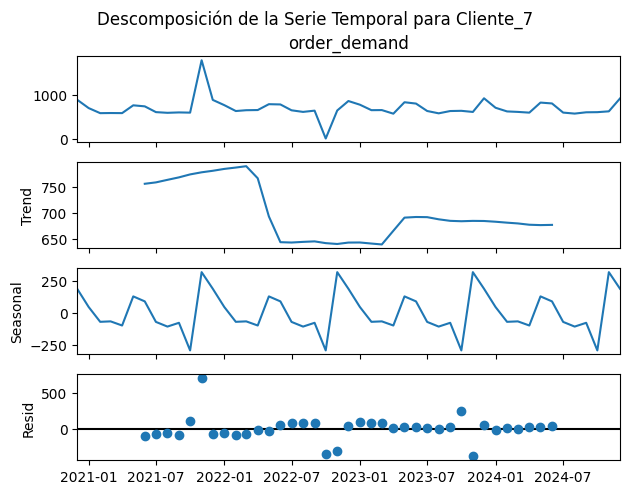

Descomponiendo serie temporal para Cliente_8...


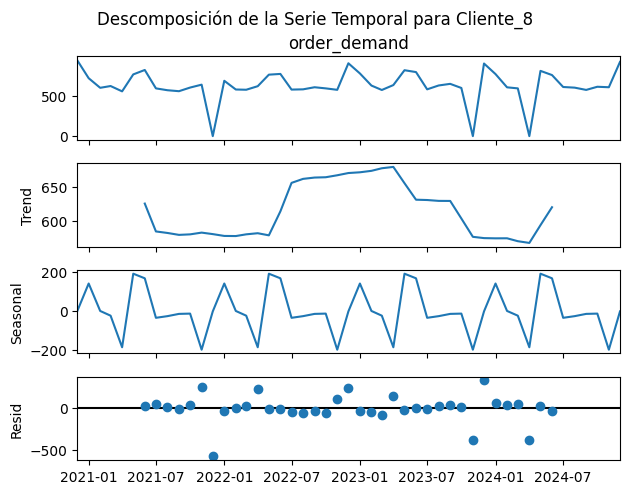

Descomponiendo serie temporal para Cliente_9...


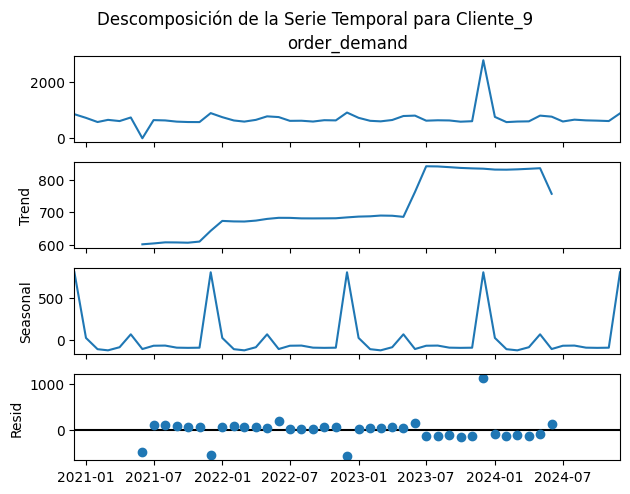

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomponer series temporales para cada cliente
for cliente, datos_cliente in clientes_data.items():
    print(f"Descomponiendo serie temporal para {cliente}...")
    datos_cliente = datos_cliente.dropna(subset=['order_demand'])
    
    decomposition = seasonal_decompose(
        datos_cliente.set_index('mes_anio_dia')['order_demand'],
        model='additive',
        period=12
    )
    
    # Graficar los componentes
    decomposition.plot()
    plt.suptitle(f"Descomposición de la Serie Temporal para {cliente}", y=1.02)
    plt.show()


2. Identificar Tendencias Globales

3. Análisis de Estacionalidad por Cliente

4. Evaluación de Estacionalidad y Ruido

Código para Modelo de Predicción con Regresión

In [22]:
# Importar las librerías necesarias
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
# Crear características temporales a partir de 'mes_anio_dia'
df_historic_order_demand['mes'] = df_historic_order_demand['mes_anio_dia'].dt.month
df_historic_order_demand['anio'] = df_historic_order_demand['mes_anio_dia'].dt.year

# Preparar el conjunto de datos para entrenamiento y prueba
# Seleccionamos las características y el objetivo
X = df_historic_order_demand[['cliente', 'mes', 'anio']]
y = df_historic_order_demand['order_demand']

In [24]:
# Codificar el cliente con números (OneHotEncoder se puede usar también)
X['cliente'] = X['cliente'].astype('category').cat.codes

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\Rafa\AppData\Local\Temp\ipykernel_1288\2774039546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cliente'] = X['cliente'].astype('category').cat.codes


In [ ]:
# Entrenar el modelo de regresión (usaremos Random Forest para este ejemplo)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

In [ ]:
# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R2): {r2}")

In [ ]:
# Predecir para el próximo mes (Ejemplo: Enero de 2025)
next_month = pd.DataFrame({
    'cliente': df_historic_order_demand['cliente'].astype('category').cat.codes.unique(),
    'mes': [1] * df_historic_order_demand['cliente'].nunique(),
    'anio': [2025] * df_historic_order_demand['cliente'].nunique()
})

next_month_predictions = model.predict(next_month)
predicted_demand = pd.DataFrame({
    'cliente': df_historic_order_demand['cliente'].astype('category').cat.categories,
    'mes_anio': '01-2025',
    'order_demand': next_month_predictions
})

print("Predicciones de demanda para Enero de 2025:")
print(predicted_demand)

Aquí están algunas técnicas que podríamos considerar:

Series Temporales (como ARIMA, SARIMA): Estos modelos son útiles para datos con tendencias y patrones estacionales, que pueden ser comunes en datos de pedidos.

Modelos de Regresión: Podemos usar regresiones lineales o múltiples si la demanda está influenciada por múltiples factores externos o internos que están representados en los datos.

Machine Learning (como Random Forests, Gradient Boosting Machines): Estos modelos pueden capturar complejidades no lineales y interacciones entre variables que los modelos más simples pueden pasar por alto.